# Repeated measurements on Starmon-5

In [1]:
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from typing import List
import itertools as it

import qiskit
import qiskit.tools.jupyter
from qiskit import QuantumCircuit
import qiskit.circuit.library.standard_gates as gates
from qiskit.tools.visualization import circuit_drawer, plot_histogram

from quantuminspire.credentials import get_token_authentication, save_account, enable_account, get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

from alive_progress import alive_it, alive_bar
from tqdm import tqdm

import pyperclip as clip


# %matplotlib notebook
%matplotlib inline
%qiskit_version_table

In [27]:
QI_URL = r'https://api.quantum-inspire.com/'
authentication = get_token_authentication()

qi = QuantumInspireAPI(QI_URL, authentication, project_name="repeated_msmts")
QI.set_authentication(authentication)
starmon5 = QI.get_backend("Starmon-5")
starmon5.status()

In [38]:
# entry for Starmon-5
qi.get_backend_types()[1]['status']

'IDLE'

In [4]:
qi.get_backend_types()[1]

OrderedDict([('url', 'https://api.quantum-inspire.com/backendtypes/11/'),
             ('name', 'Starmon-5'),
             ('is_hardware_backend', True),
             ('required_permission', 'can_execute'),
             ('number_of_qubits', 5),
             ('description', ''),
             ('topology',
              OrderedDict([('edges', [[2], [2], [0, 1, 3, 4], [2], [2]])])),
             ('is_allowed', True),
             ('status', 'EXECUTION'),
             ('status_message', ''),
             ('chip_image_id', '4386293'),
             ('calibration',
              'https://api.quantum-inspire.com/backendtypes/11/calibration/'),
             ('allowed_operations',
              OrderedDict([('display', []),
                           ('measure',
                            ['measure',
                             'measure_x',
                             'measure_y',
                             'measure_z']),
                           ('measure_all', ['measure_all']),
         

In [5]:
EXP_NAME = "QUBIT_Q_MSMTS_N"

## Build circuit

In [32]:

qubit = 2
qc = QuantumCircuit(5,5)
# qc.x(qubit)
# for _ in range(10):
#     qc.measure(qubit, qubit)

t1 = time.perf_counter()
# qc.x(qubit)
# qc.measure(qubit, qubit)
# qc.measure(qubit, qubit)
qc.rx(round(np.pi, 8)/2, qubit)
# qc.barrier(range(5))
qc.measure(qubit, qubit)
qc.measure(qubit, qubit)
qc.id(qubit-1)
qc.measure(qubit-1, qubit-1)
qc.id(qubit+1)
qc.measure(qubit+1, qubit+1)
qc.draw(output='latex_source')

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{q}_{0} :  } & \\lstick{{q}_{0} :  } & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{1} :  } & \\lstick{{q}_{1} :  } & \\gate{\\mathrm{I}} & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{2} :  } & \\lstick{{q}_{2} :  } & \\gate{\\mathrm{R_X}\\,(\\mathrm{\\frac{\\pi}{2}})} & \\meter & \\qw & \\qw & \\meter & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{3} :  } & \\lstick{{q}_{3} :  } & \\gate{\\mathrm{I}} & \\qw & \\qw & \\meter & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{4} :  } & \\lstick{{q}_{4} :  } & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{\\mathrm{{c} :  }} & \\lstick{\\mathrm{{c} :  }} & \\lstick{/_{_{5}}} \\cw & \\dstick{_{_{\\hspace{0.0em}2}}} \\cw \\ar @{<=} [-3,0] & \\dstick{_{_{\\hspace{0.0em}1}}} \\cw \\ar @{<=} [-4,

In [33]:
clip.copy(_)

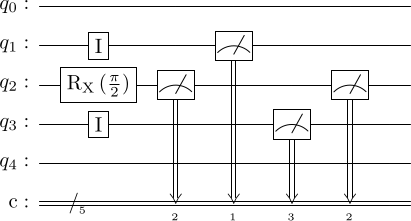

In [28]:
circuit_drawer(qc, output='latex')

In [62]:
header = ['# ' + line for line in str(qc.draw(output='text')).split('\n')]
header = '\n'.join(header)
print(header)

#                         
# q_0: ───────────────────
#      ┌───┐        ┌─┐   
# q_1: ┤ I ├────────┤M├───
#      └┬─┬┘     ┌─┐└╥┘   
# q_2: ─┤M├──────┤M├─╫────
#       └╥┘ ┌───┐└╥┘ ║ ┌─┐
# q_3: ──╫──┤ I ├─╫──╫─┤M├
#        ║  └───┘ ║  ║ └╥┘
# q_4: ──╫────────╫──╫──╫─
#        ║        ║  ║  ║ 
# c: 5/══╩════════╩══╩══╩═
#        2        2  1  3 


## Send job and retrieve result

In [31]:
t1 = time.perf_counter()
job = qiskit.execute(qc, shots=2**14, optimization_level=2, backend=starmon5)
job.result()
t2 = time.perf_counter()
print(f"Total execution time: {(t2-t1):.2f} sec") # (~{(t2-t1)/60/len(qiskit_circuits):.2f} min per circuit)")

Total execution time: 46.99 sec


In [45]:
res.data().keys()

dict_keys(['counts', 'memory', 'probabilities', 'counts_multiple_measurement', 'memory_multiple_measurement', 'probabilities_multiple_measurement', 'calibration'])

In [32]:
job.result().get_counts()

{'00000': 15149,
 '00010': 186,
 '00100': 563,
 '00110': 7,
 '01000': 463,
 '01010': 1,
 '01100': 15}

In [33]:
job.result().get_probabilities_multiple_measurement()


[{'00000': 0.98028564453125, '00100': 0.01971435546875},
 {'00000': 0.92462158203125,
  '00010': 0.0113525390625,
  '00100': 0.03436279296875,
  '00110': 0.00042724609375,
  '01000': 0.02825927734375,
  '01010': 6.103515625e-05,
  '01100': 0.00091552734375}]

In [81]:
job.result().data()['counts_multiple_measurement']

[{'0x0': 16061, '0x4': 323},
 {'0x0': 15149,
  '0x2': 186,
  '0x4': 563,
  '0x6': 7,
  '0x8': 463,
  '0xa': 1,
  '0xc': 15}]

In [34]:
print(np.asarray(job.result().data()['memory_multiple_measurement']).shape)
np.asarray(job.result().data()['memory_multiple_measurement'])


(2, 16384)


array([['0x0', '0x0', '0x0', ..., '0x0', '0x0', '0x0'],
       ['0x0', '0x0', '0x0', ..., '0x0', '0x0', '0x0']], dtype='<U3')

In [46]:
print(np.asarray(job.result().data()['memory']).shape)
np.asarray(job.result().data()['memory'])

(16384,)


array(['0x0', '0x0', '0x0', ..., '0x0', '0x0', '0x0'], dtype='<U3')

In [38]:
1024*4*3

12288

## Save result data

In [23]:
with open(EXP_NAME.replace('_Q', f'_{qubit}') + '.csv', 'w') as f:
    f.write('\n'.join(header))

In [35]:
with open(EXP_NAME.replace('_Q', f'_{qubit}') + '_PROB' + '.json', 'w') as f:
    f.writelines('\n'.join(map(json.dumps, job.result().get_probabilities_multiple_measurement())))

In [39]:
with open(EXP_NAME.replace('_Q', f'_{qubit}') + '_PROB' + '.json', 'r') as f:
    a = json.loads(f.read())
a[1]

{'00000': 0.92462158203125,
 '00010': 0.0113525390625,
 '00100': 0.03436279296875,
 '00110': 0.00042724609375,
 '01000': 0.02825927734375,
 '01010': 6.103515625e-05,
 '01100': 0.00091552734375}

In [7]:
def save_exp_result(job, exp_name: str, header: str=None, directory: str='./data/'):
    np.savetxt(fname=directory + exp_name + '_RAW.csv',
               X=np.array(job.result().data()['memory_multiple_measurement']),
               delimiter=',',
               fmt='%s',
               header=header)

    with open(directory + exp_name + '_PROB.json', 'w') as f:
        f.write(header + '\n')
        f.write(json.dumps(job.result().get_probabilities_multiple_measurement()))

    with open(directory + exp_name + '_COUNTS.json', 'w') as f:
        f.write(header + '\n')
        f.write(json.dumps(job.result().data()['counts_multiple_measurement']))

    return

In [129]:
save_exp_result(job, EXP_NAME.replace('_Q', f'_{qubit}'), header)

## Simple N msmts per qubit without msmt crosstalk

In [82]:
for qb in range(5):
    for N in [2,4,10]:
        print(qb, N)
        circuit = QuantumCircuit(5,5)
        circuit.x(qb)
        for _ in range(N):
            circuit.measure(qb, qb)

        job = qiskit.execute(circuit, shots=2**14, optimization_level=2, backend=starmon5)
        header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
        save_exp_result(job, f"qubit_{qb}_msmts_{N}", header)


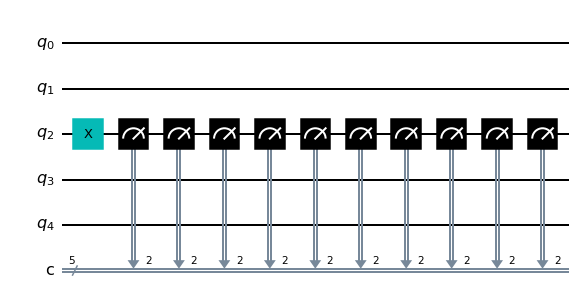

In [4]:
qb = 2
N = 10
circuit = QuantumCircuit(5,5)
circuit.x(qb)
[circuit.measure(qb, qb) for _ in range(N)]

circuit_drawer(circuit, output='mpl')

## QND circuit per qubit

In [20]:
for qb in tqdm(range(5)):
    print(f"QND for qubit {qb}...")
    circuit = QuantumCircuit(5,5)
    circuit.rx(np.pi/2, qb)
    circuit.measure(qb, qb)
    circuit.measure(qb, qb)
    circuit.x(qb)
    circuit.measure(qb, qb)

    job = qiskit.execute(circuit, shots=2**14, optimization_level=2, backend=starmon5)
    header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
    save_exp_result(job, f"qubit_{qb}_QND_v2", header)

  0%|          | 0/5 [00:00<?, ?it/s]

QND for qubit {qb}...


 20%|██        | 1/5 [01:21<05:26, 81.61s/it]

QND for qubit {qb}...


 40%|████      | 2/5 [03:13<04:58, 99.62s/it]

QND for qubit {qb}...


 60%|██████    | 3/5 [05:04<03:29, 104.69s/it]

QND for qubit {qb}...


 80%|████████  | 4/5 [06:57<01:48, 108.05s/it]

QND for qubit {qb}...


100%|██████████| 5/5 [08:47<00:00, 105.41s/it]


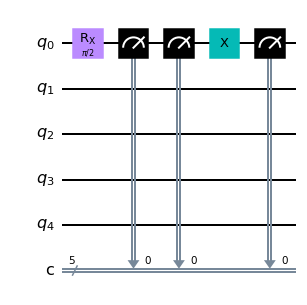

In [7]:
qb = 0
circuit = QuantumCircuit(5,5)
circuit.rx(np.pi/2, qb)
circuit.measure(qb, qb)
circuit.measure(qb, qb)
circuit.x(qb)
circuit.measure(qb, qb)
circuit_drawer(circuit, output='mpl')

# job = qiskit.execute(circuit, shots=2**14, optimization_level=2, backend=starmon5)
# header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])

In [89]:
job.result()

Result(backend_name='Starmon-5', backend_version='2.0.0', qobj_id='7147404', job_id='7147404', success=True, results=[ExperimentResult(shots=16384, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 5021, '0x1': 11363}, memory=['0x0', '0x1', '0x1', '0x1', '0x0', '0x1', '0x1', '0x1', '0x1', '0x1', '0x1', '0x1', '0x0', '0x1', '0x1', '0x1', '0x0', '0x1', '0x1', '0x0', '0x0', '0x0', '0x0', '0x1', '0x1', '0x1', '0x1', '0x0', '0x0', '0x1', '0x0', '0x0', '0x1', '0x0', '0x1', '0x1', '0x0', '0x1', '0x1', '0x1', '0x0', '0x0', '0x1', '0x1', '0x1', '0x1', '0x0', '0x0', '0x0', '0x0', '0x0', '0x1', '0x1', '0x1', '0x1', '0x0', '0x1', '0x1', '0x1', '0x0', '0x1', '0x0', '0x0', '0x1', '0x1', '0x0', '0x0', '0x1', '0x0', '0x0', '0x0', '0x1', '0x1', '0x1', '0x1', '0x0', '0x0', '0x0', '0x1', '0x0', '0x1', '0x1', '0x1', '0x1', '0x1', '0x1', '0x1', '0x1', '0x0', '0x0', '0x1', '0x1', '0x0', '0x0', '0x0', '0x0', '0x1', '0x0', '0x1', '0x1', '0x1', '0x0', '0x1', '0x0', '0x0', '0x0', '0x0', '0x1'

## msmt induced dephasing

### initial test (qubit 3 -> 2)

In [100]:

circuit = QuantumCircuit(5,5)
circuit.rx(np.pi/2, 2)
circuit.id(3)
circuit.barrier(range(5))
# circuit.measure(3,3)
for _ in range(100):
    circuit.id(2)
circuit.barrier(range(5))
circuit.id(3)
circuit.rx(np.pi/2, 2)
circuit.measure(2,2)

job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=starmon5)
header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])

In [ ]:
job.result()

In [95]:
# with msmt on qubit 3
job.result().get_probabilities_multiple_measurement()

[{'00000': 0.9794921875, '01000': 0.0205078125},
 {'00000': 0.1082763671875, '00100': 0.8917236328125}]

In [99]:
# without msmt on qubit 3
job.result().get_probabilities_multiple_measurement()

[{'00000': 0.03765869140625, '00100': 0.96234130859375}]

In [101]:
# without msmt on qubit 3, but 100xId on qubit 2 instead
job.result().get_probabilities_multiple_measurement()


[{'00000': 0.1331787109375, '00100': 0.8668212890625}]

In [112]:
np.savetxt('a.txt', np.asarray(job.result().data()['memory']), fmt='%s')


In [126]:
a = np.loadtxt('a.txt', dtype='<U3')
# int(a[1], base=2)

"{0:05b}".format(int(a[1], 16))


'00100'

In [77]:
def measure_msmt_induced_dephasing(
        measured_qb: int,
        tested_qb: int=None,
        id_gates: bool=True,
        do_tomography: bool=True,
        filename: str="msmt_induced_dephasing_qb_{}_on_qb_{}",
        show_circuit: bool=True,
        send_jobs: bool=True
):
    jobs = []
    circuits = []
    if do_tomography:
        # tomo_gates = {'X': ('ry', -np.pi/2), 'Y': ('rx', np.pi/2), 'Z': ('id',  None)}
        tomo_gates = {'X': gates.RYGate(-np.pi/2), 'Y': gates.RXGate(np.pi/2), 'Z': gates.IGate()}
    else:
        # tomo_gates = {'Z': ('id', None)}
        tomo_gates = {'Z': gates.IGate()}

    for tomo_option, gate in tomo_gates.items():
        circuit = QuantumCircuit(5,5)
        circuit.rx(np.pi/2, measured_qb)
        if tested_qb is not None: # can't autocast here, qb can be 0!
            circuit.id(tested_qb)
        circuit.barrier(range(5))
        if tested_qb is not None: # can't autocast here, qb can be 0!
            circuit.measure(tested_qb, tested_qb)
        if id_gates:
            # 100 x 20ns ID gate = 2mus = msmt length
            for _ in range(100):
                circuit.id(measured_qb)
        circuit.barrier(range(5))
        circuit.rx(np.pi/2, measured_qb)

        circuit.barrier(range(5))
        # getattr(circuit, gate)(angle, measured_qb) if angle is not None else getattr(circuit, gate)(measured_qb)
        circuit.append(gate, [measured_qb])
        circuit.measure(measured_qb, measured_qb)
        circuits += [circuit]

        if show_circuit:
            display(circuit.draw(output='mpl'))

        header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
        exp_name = filename.format(tested_qb, measured_qb) + f"_M{tomo_option}" if do_tomography else filename.format(tested_qb, measured_qb)
        exp_name = exp_name + "_noIDs" if not id_gates else exp_name
        print(exp_name)

        if send_jobs:
            job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=starmon5)
            save_exp_result(job, exp_name, header)
            jobs += [job]

    return jobs, circuits

### qubit 1 -> qubit 2 (different feedlines, connected)

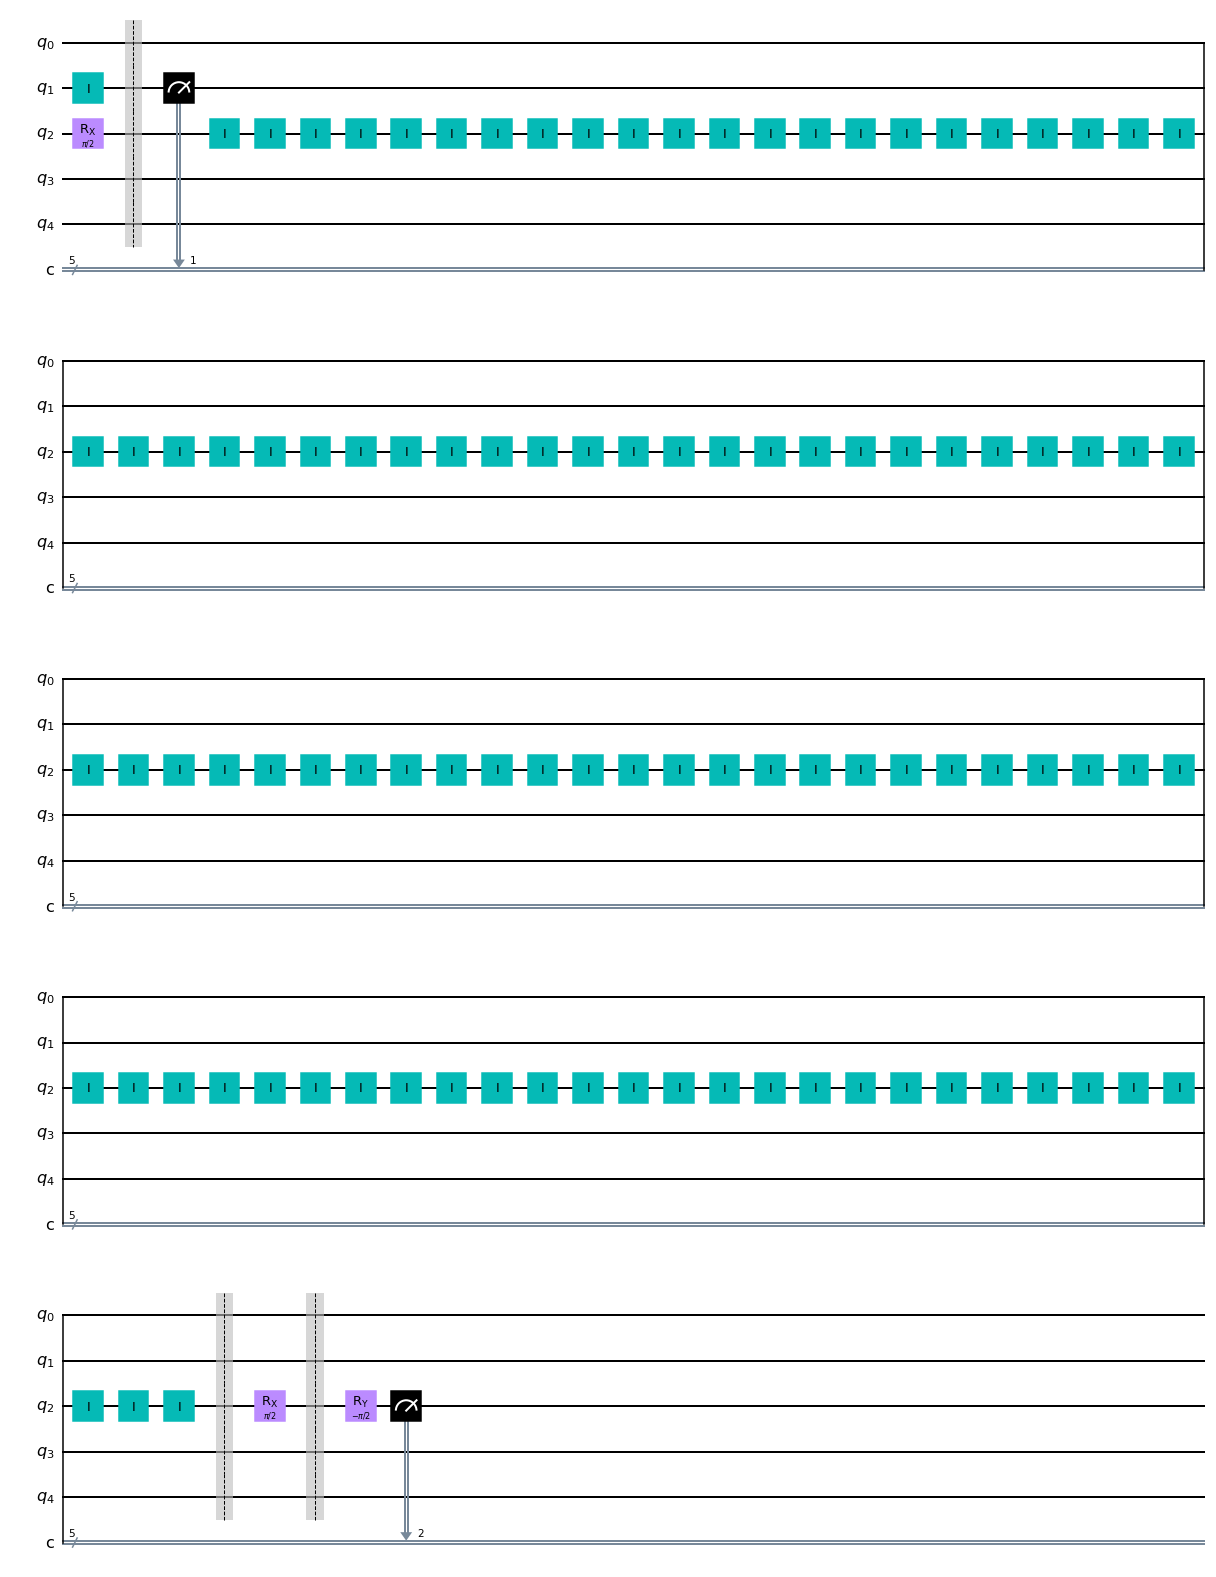

msmt_induced_dephasing_qb_1_on_qb_2_MX


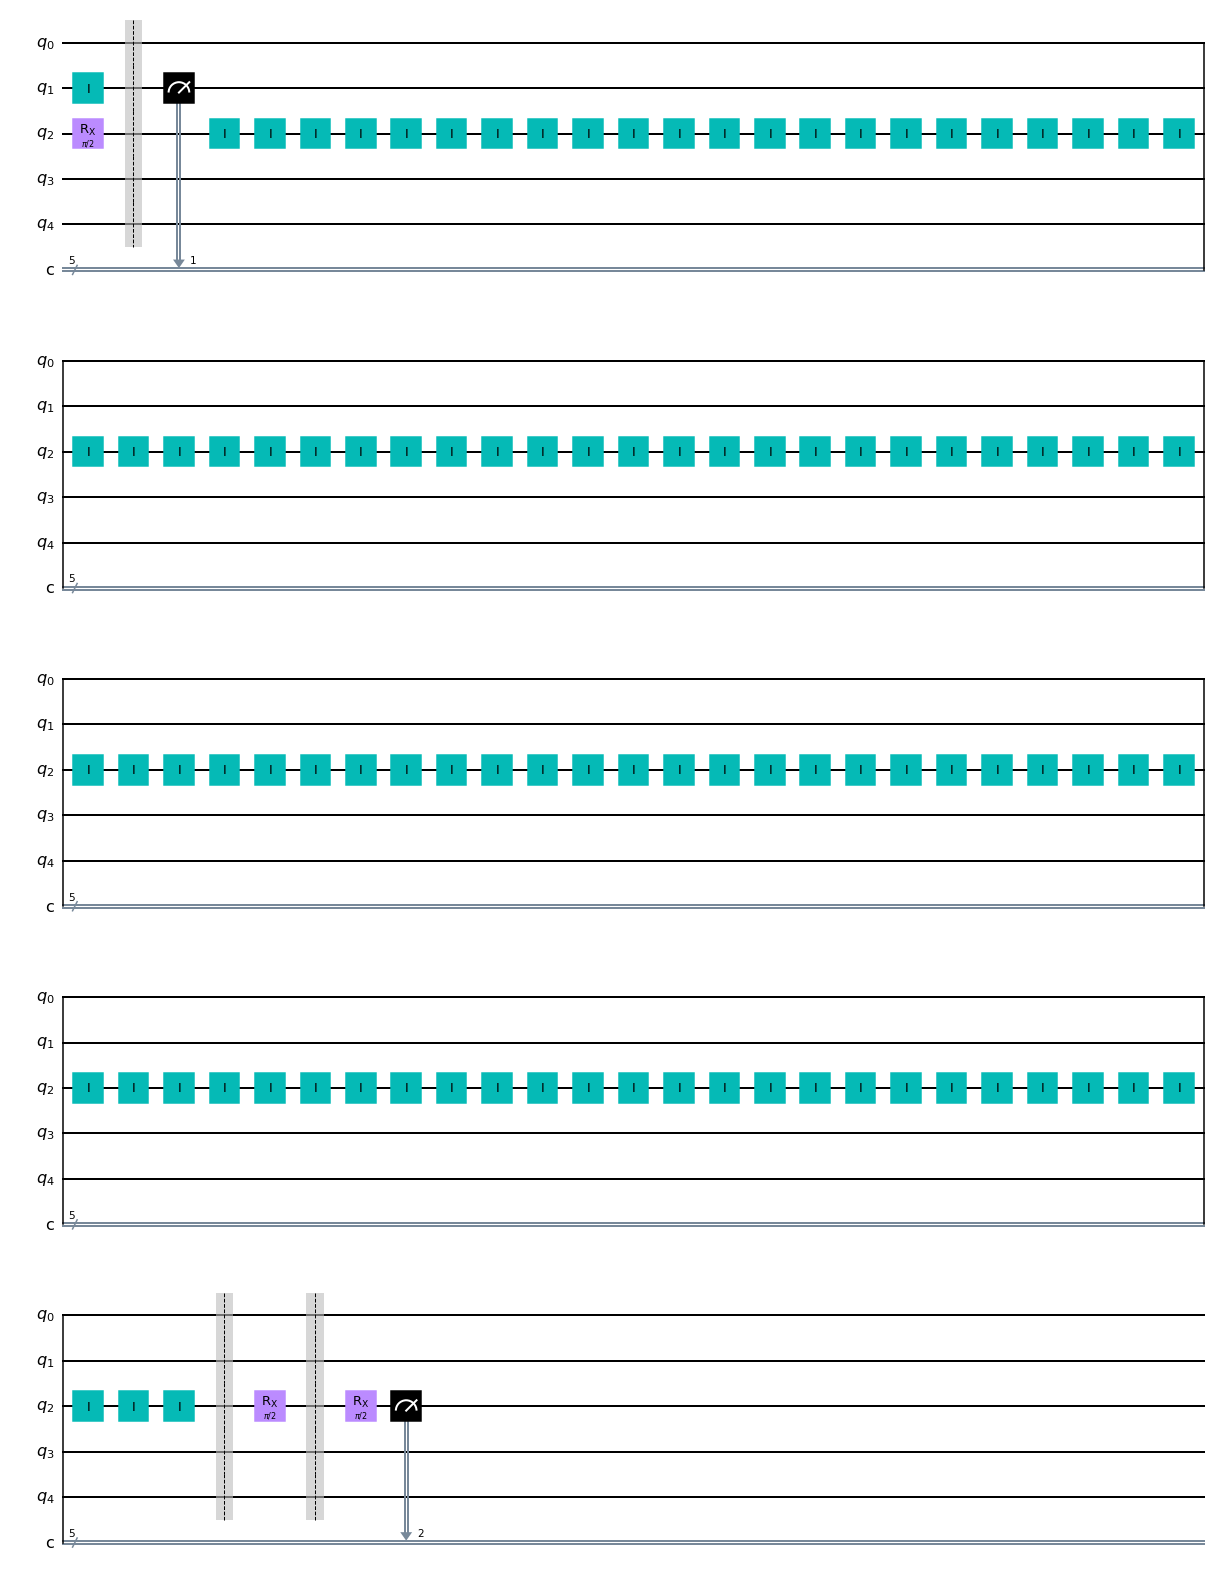

msmt_induced_dephasing_qb_1_on_qb_2_MY


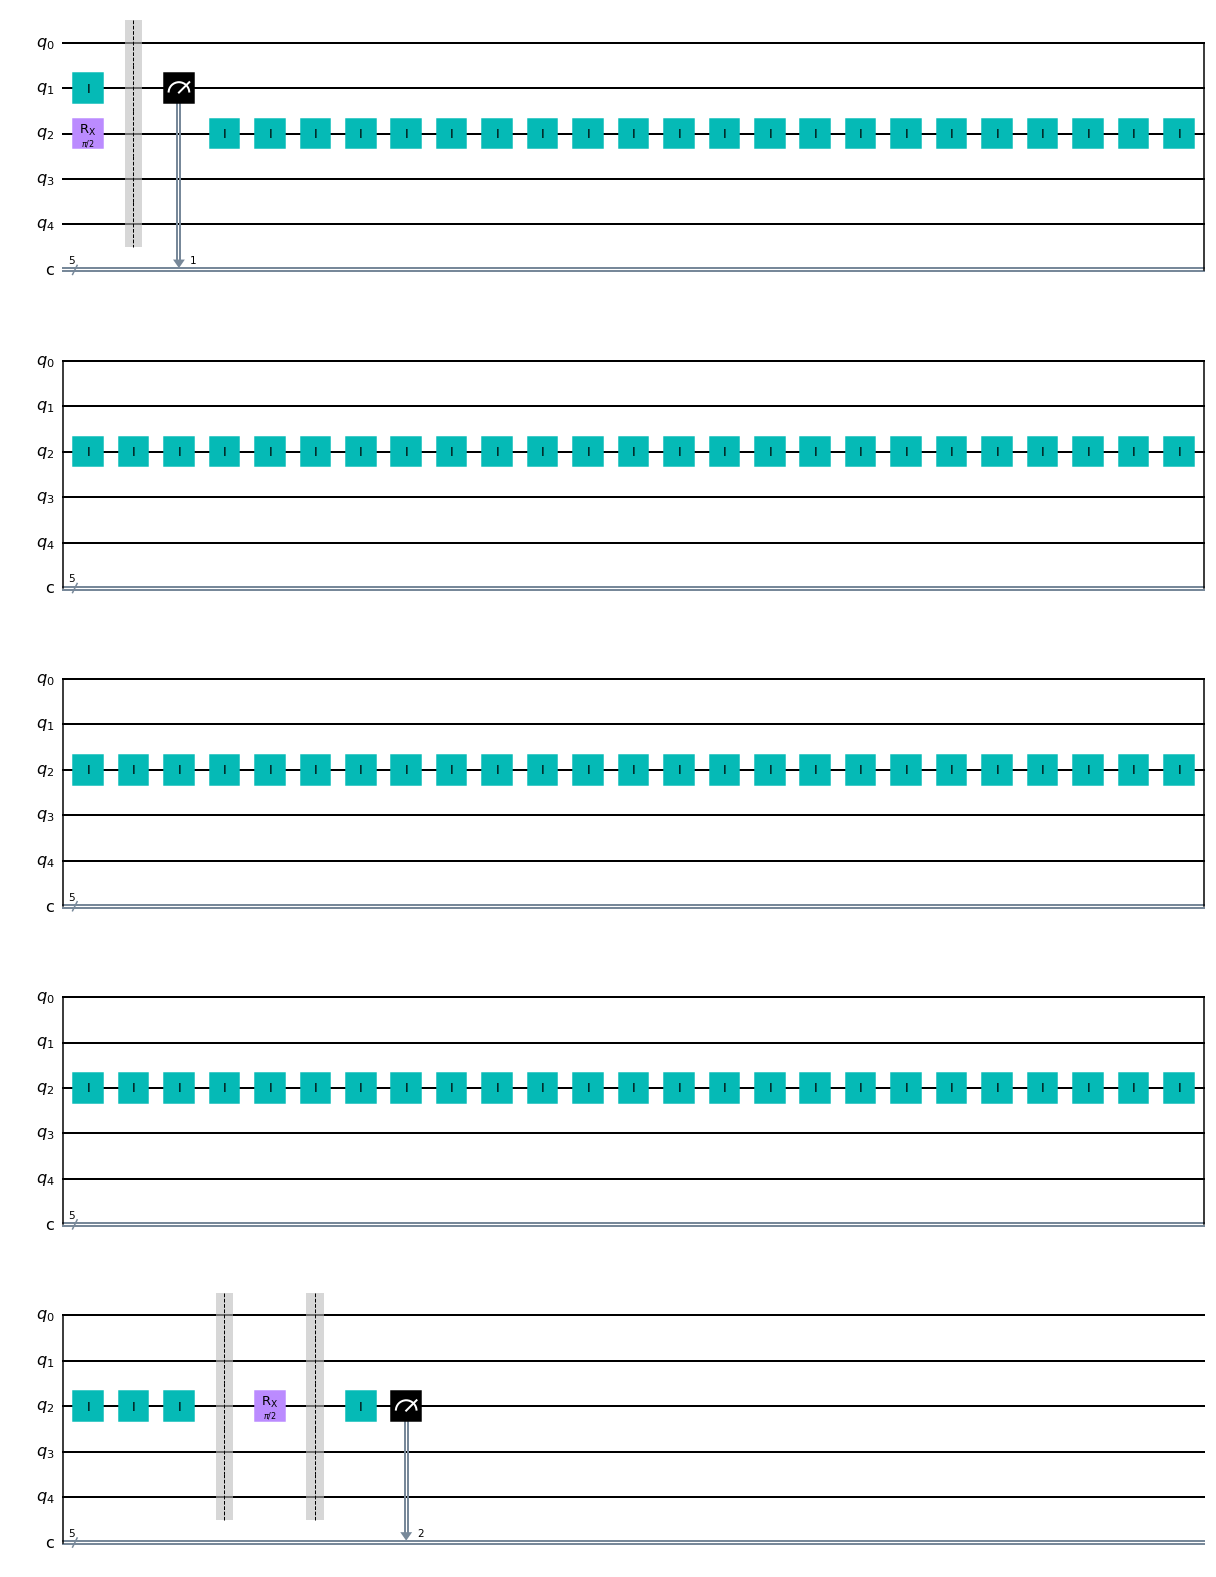

msmt_induced_dephasing_qb_1_on_qb_2_MZ


([],
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe6f690fa90>])

In [78]:
measure_msmt_induced_dephasing(2, 1, do_tomography=True, show_circuit=True)

In [58]:
measure_msmt_induced_dephasing(2, None, show_circuit=False)

msmt_induced_dephasing_qb_None_on_qb_2_MX
msmt_induced_dephasing_qb_None_on_qb_2_MY
msmt_induced_dephasing_qb_None_on_qb_2_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe72b50ffa0>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d6893a0>])

In [27]:
measure_msmt_induced_dephasing(2, None, id_gates=False)

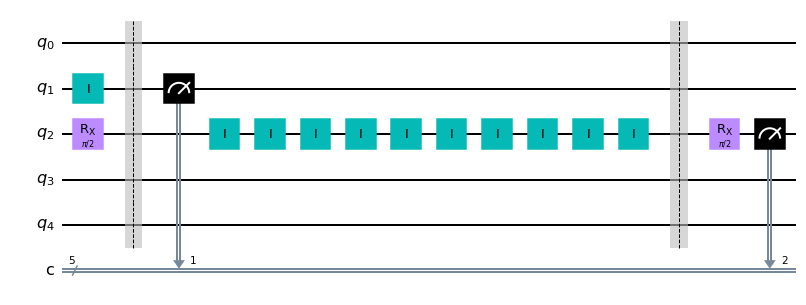

In [12]:
measured_qb = 2
tested_qb = 1


circuit = QuantumCircuit(5,5)
circuit.rx(np.pi/2, measured_qb)
if tested_qb:
    circuit.id(tested_qb)
circuit.barrier(range(5))
# 100 x 20ns ID gate = 2mus = msmt length
if tested_qb is not None:
    circuit.measure(tested_qb, tested_qb)
for _ in range(10):
    circuit.id(measured_qb)
circuit.barrier(range(5))
circuit.rx(np.pi/2, measured_qb)
circuit.measure(measured_qb, measured_qb)
circuit_drawer(circuit, output='mpl')

In [12]:
"msmt_induced_dephasing_qb_{}_on_qb_{}".format(1,2)

'msmt_induced_dephasing_qb_1_on_qb_2'

### qubit 3 -> qubit 2 (same feedline, connected)

In [59]:
measure_msmt_induced_dephasing(2, 3, show_circuit=False)

msmt_induced_dephasing_qb_3_on_qb_2_MX
msmt_induced_dephasing_qb_3_on_qb_2_MY
msmt_induced_dephasing_qb_3_on_qb_2_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe6f5ff0910>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d74e100>])

In [60]:
measure_msmt_induced_dephasing(2, None, show_circuit=False)

msmt_induced_dephasing_qb_None_on_qb_2_MX
msmt_induced_dephasing_qb_None_on_qb_2_MY
msmt_induced_dephasing_qb_None_on_qb_2_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe70d067f10>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d778d60>])

### qubit 2 -> qubit 3 (same feedline, connected)

In [61]:
measure_msmt_induced_dephasing(3, 2, show_circuit=False)

msmt_induced_dephasing_qb_2_on_qb_3_MX
msmt_induced_dephasing_qb_2_on_qb_3_MY
msmt_induced_dephasing_qb_2_on_qb_3_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe70cca2550>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d31e280>])

In [62]:
measure_msmt_induced_dephasing(3, None, show_circuit=False)

msmt_induced_dephasing_qb_None_on_qb_3_MX
msmt_induced_dephasing_qb_None_on_qb_3_MY
msmt_induced_dephasing_qb_None_on_qb_3_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe70cd138e0>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d7fbfa0>])

### qubit 4 -> qubit 2 (same feedline, connected)

In [63]:
measure_msmt_induced_dephasing(2, 4, show_circuit=False)

msmt_induced_dephasing_qb_4_on_qb_2_MX
msmt_induced_dephasing_qb_4_on_qb_2_MY
msmt_induced_dephasing_qb_4_on_qb_2_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe70cd96130>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d3d4160>])

In [64]:
measure_msmt_induced_dephasing(2, None, show_circuit=False)

msmt_induced_dephasing_qb_None_on_qb_2_MX
msmt_induced_dephasing_qb_None_on_qb_2_MY
msmt_induced_dephasing_qb_None_on_qb_2_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe70d0ba460>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70ca12b80>])

### qubit 0 -> qubit 2 (same feedline, connected)

In [65]:
measure_msmt_induced_dephasing(2, 0, show_circuit=False)


msmt_induced_dephasing_qb_0_on_qb_2_MX
msmt_induced_dephasing_qb_0_on_qb_2_MY
msmt_induced_dephasing_qb_0_on_qb_2_MZ


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fe70ca1cac0>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fe70d8790a0>])

In [48]:
job.result().data()['probabilities']


{'0x0': 0.15740966796875, '0x4': 0.84259033203125}

### Correction for readout errors

In [85]:
def measure_readout_correction(
        measured_qb: int,
        filename: str="readout_correction_qb_{}",
        show_circuit: bool=True
):
    jobs = []
    circuits = []

    for state in [0, 1]:
        circuit = QuantumCircuit(5,5)
        if 1 == state:
            circuit.x(measured_qb)
        circuit.measure(measured_qb, measured_qb)
        circuits += [circuit]

        if show_circuit:
            display(circuit.draw(output='mpl', interactive=False))

        header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
        exp_name = filename.format(measured_qb) + f"_state{state}"
        print(exp_name)

        job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=starmon5)
        save_exp_result(job, exp_name, header)
        jobs += [job]

    return jobs, circuits

In [ ]:
measure_readout_correction(2)
measure_readout_correction(3)


## Entanglement by msmt


In [133]:
tomo_gates = {}
print(list(it.product(tomo_gates.keys(), repeat=2)))

[]


In [36]:
def measure_entanglement_by_msmt(
        qubits: List[int],
        tomo_qubits: List[int]=[],
        sim_msmt: bool=True,
        filename: str="entanglement_by_msmt_qbs",
        show_circuit: bool=True,
        send_jobs: bool=True
):
    jobs = []
    circuits = []
    if tomo_qubits:
        tomo_gates = {'X': gates.RYGate(-np.pi/2), 'Y': gates.RXGate(np.pi/2), 'Z': gates.IGate()}
        tomo_combinations = it.product(tomo_gates.keys(), repeat=2)
    else:
        tomo_combinations = ['Z']

    for tomo_option in tqdm(tomo_combinations, total=len(tomo_combinations)):
        circuit = QuantumCircuit(5,5)
        # circuit.rx(np.pi/2, qubits[1])
        # circuit.ry(-np.pi/2, qubits[0])
        # circuit.ry(-np.pi/2, qubits[2])

        for qb in qubits:
            circuit.ry(np.pi/2, qb)

        circuit.barrier(range(5))
        circuit.cz(qubits[1], qubits[0])
        circuit.id(qubits[1])
        circuit.id(qubits[1])
        circuit.cz(qubits[1], qubits[2])
        circuit.barrier(range(5))

        for qb in qubits:
            circuit.ry(-np.pi/2, qb)

        # circuit.rx(np.pi/2, qubits[1])
        # circuit.ry(np.pi/2, qubits[0])
        # circuit.ry(np.pi/2, qubits[2])
        circuit.barrier(range(5))
        if qubits[1] in tomo_qubits:
            idx = tomo_qubits.index(qubits[1])
            circuit.append(tomo_gates[tomo_option[idx]], [qubits[1]])
        elif sim_msmt:
            circuit.id(qubits[1])
        circuit.measure(qubits[1], qubits[1])


        # for qb in set(qubits).intersection(tomo_qubits):
        #     idx = tomo_qubits.index(qb)
        #     circuit.append(tomo_gates[tomo_option[idx]], [qb])
        #     circuit.measure(qb, qb)

        if not sim_msmt:
            # add waiting time via ID gates on data qubits
            for _ in range(100):
                circuit.id(qubits[0])
                circuit.id(qubits[-1])
            circuit.barrier(range(5))

        # for qb in set(qubits).difference(tomo_qubits):
        #     circuit.id(qb)
        #     circuit.measure(qb, qb)

        if qubits[0] in tomo_qubits:
            idx = tomo_qubits.index(qubits[0])
            circuit.append(tomo_gates[tomo_option[idx]], [qubits[0]])
        elif sim_msmt:
            circuit.id(qubits[0])
        circuit.measure(qubits[0], qubits[0])

        if qubits[2] in tomo_qubits:
            idx = tomo_qubits.index(qubits[2])
            circuit.append(tomo_gates[tomo_option[idx]], [qubits[2]])
        elif sim_msmt:
            circuit.id(qubits[2])
        circuit.measure(qubits[2], qubits[2])

        if show_circuit:
            display(circuit.draw(output='mpl', scale=1))
        circuits += [circuit]

        if send_jobs:
            header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
            exp_name = filename + str(qubits) + f"_tom{tomo_qubits}" + f"_M{tomo_option}" if tomo_qubits else filename + str(qubits)
            exp_name = exp_name + "_sim-msmt" if sim_msmt else exp_name
            print(qi.get_backend_types()[1]['status'])
            print("Sending job: ", exp_name)
            job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=starmon5)
            save_exp_result(job, exp_name, header)
            # check status of queue
            jobs += [job]

    return jobs, circuits


In [39]:
jobs, circuits = measure_entanglement_by_msmt([1,2,3], tomo_qubits=[1,3], filename="entanglement_by_msmt_qbs", send_jobs=True, sim_msmt=False, show_circuit=False)

0it [00:00, ?it/s]

IDLE
Sending job:  entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('X', 'X')


1it [00:52, 52.15s/it]

IDLE
Sending job:  entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('X', 'Y')


2it [01:40, 50.12s/it]

EXECUTION
Sending job:  entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('X', 'Z')


2it [01:50, 55.13s/it]


KeyboardInterrupt: 

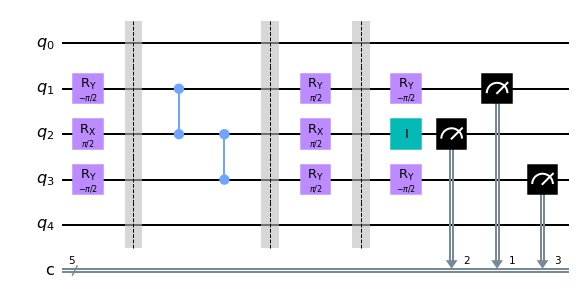

In [43]:
circuits[0].draw(output='mpl')

In [23]:
job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=starmon5)
header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
save_exp_result(job, f"entaglement_via_msmt_qubits_[1,2,3]", header)


In [22]:
job.result().data()['probabilities_multiple_measurement']

[{'0x0': 0.06524658203125,
  '0x2': 0.166259765625,
  '0x4': 0.06964111328125,
  '0x6': 0.147705078125,
  '0x8': 0.09326171875,
  '0xa': 0.232666015625,
  '0xc': 0.067138671875,
  '0xe': 0.1580810546875}]

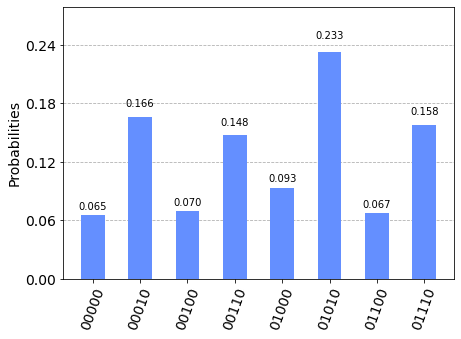

In [23]:
plot_histogram(data=job.result().get_probabilities_multiple_measurement())


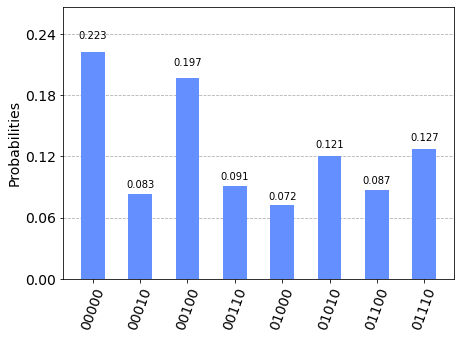

In [18]:
plot_histogram(data=job.result().get_probabilities_multiple_measurement())


### Correction for two-qubit readout errors

In [22]:
def measure_two_qubit_readout_correction(
        qubits: tuple,
        filename: str="readout_correction_qbs{}",
        show_circuit: bool=True
):
    jobs = []
    circuits = []

    for state in ['00','01','10','11']:
        circuit = QuantumCircuit(5,5)
        if state[0] == '1':
            circuit.x(qubits[0])
        else:
            circuit.id(qubits[0])
        if state[1] == '1':
            circuit.x(qubits[1])
        else:
            circuit.id(qubits[1])
        circuit.barrier(range(5))
        circuit.measure(qubits[0], qubits[0])
        circuit.measure(qubits[1], qubits[1])
        circuits += [circuit]

        if show_circuit:
            display(circuit.draw(output='mpl', interactive=False))

        header = '\n'.join(['# ' + line for line in str(circuit.draw(output='text')).split('\n')])
        exp_name = filename.format(qubits) + f"_state{state}"
        print(exp_name)

        job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=starmon5)
        save_exp_result(job, exp_name, header)
        jobs += [job]

    return jobs, circuits

In [23]:
measure_two_qubit_readout_correction([1,3], filename="readout_correction_qbs{}", show_circuit=False)


readout_correction_qbs[1, 3]_state00
readout_correction_qbs[1, 3]_state01
readout_correction_qbs[1, 3]_state10
readout_correction_qbs[1, 3]_state11


([<quantuminspire.qiskit.qi_job.QIJob at 0x7fabce2d9490>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fabcca91520>])

In [ ]:
out = _

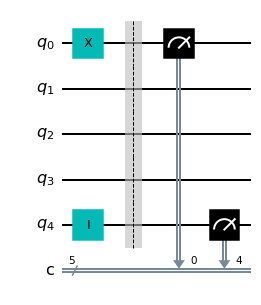

In [15]:
out[1][-2].draw(output='mpl')
